# Senegalese tax and benefit system from scratch

In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
from openfisca_core.columns import IntCol, DateCol, FloatCol
from openfisca_core.formulas import set_input_divide_by_period
from openfisca_core.variables import Variable

from openfisca_senegal import SenegalTaxBenefitSystem
from openfisca_senegal.entities import Individus

In [3]:
tax_benefit_system = SenegalTaxBenefitSystem()

In [4]:
tax_benefit_system.add_legislation_params(u'''
<NODE code="root">
  <BAREME code="bareme_impot_progressif" type="monetary">
    <TRANCHE code="tranche0">
      <SEUIL>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="0" />
      </SEUIL>
      <TAUX>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="0" />
      </TAUX>
    </TRANCHE>
    <TRANCHE code="tranche1">
      <SEUIL>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="630000" />
      </SEUIL>
      <TAUX>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="0.2" />
      </TAUX>
    </TRANCHE>
    <TRANCHE code="tranche2">
      <SEUIL>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="1500000" />
      </SEUIL>
      <TAUX>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="0.3" />
      </TAUX>
    </TRANCHE>
    <TRANCHE code="tranche3">
      <SEUIL>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="4000000" />
      </SEUIL>
      <TAUX>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="0.35" />
      </TAUX>
    </TRANCHE>
    <TRANCHE code="tranche4">
      <SEUIL>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="8000000" />
      </SEUIL>
      <TAUX>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="0.37" />
      </TAUX>
    </TRANCHE>
    <TRANCHE code="tranche5">
      <SEUIL>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="13500000" />
      </SEUIL>
      <TAUX>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="0.4" />
      </TAUX>
    </TRANCHE>
  </BAREME>
</NODE>
''')

In [5]:
class id_famille(Variable):
    column = IntCol
    entity_class = Individus
    is_permanent = True
    label = u"Identifiant de la famille"

tax_benefit_system.update_variable(id_famille)

class role_dans_famille(Variable):
    column = IntCol
    entity_class = Individus
    is_permanent = True
    label = u"Rôle dans la famille"

tax_benefit_system.update_variable(role_dans_famille)

class date_de_naissance(Variable):
    column = DateCol
    entity_class = Individus
    label = u"Date de naissance"

tax_benefit_system.update_variable(date_de_naissance)

class salaire(Variable):
    column = FloatCol
    entity_class = Individus
    label = "Salaire"
    set_input = set_input_divide_by_period

tax_benefit_system.update_variable(salaire)

class impot_progressif(Variable):
    column = FloatCol
    entity_class = Individus
    label = u"Impôt sur le revenu"

    def function(self, simulation, period):
        salaire = simulation.calculate_add('salaire', period)
        bareme_impot_progressif = simulation.legislation_at(period.start).bareme_impot_progressif
        return period, bareme_impot_progressif.calc(salaire)

tax_benefit_system.update_variable(impot_progressif)

tax_benefit_system

In [6]:
scenario = tax_benefit_system.new_scenario()

In [7]:
scenario.init_single_entity(
    parent1={'salaire': 1800000},
    period='2015',
)

In [8]:
simulation = scenario.new_simulation()

In [9]:
simulation.calculate('salaire', period='2015')

array([ 1800000.], dtype=float32)

In [11]:
simulation.calculate('impot_progressif', period='2015')

array([ 264000.], dtype=float32)

In [14]:
(1500000 - 630000) * 0.2 + (1800000 - 1500000) * 0.3

264000.0

## Simuler plusieurs cas types à la fois

In [16]:
scenario2 = tax_benefit_system.new_scenario()

In [42]:
scenario2.init_single_entity(
    parent1={'salaire': 1800000},
    period='2015',
    axes=[
        {
            'count': 100,
            'min': 0,
            'max': 3e6,
            'name': 'salaire',
        }
    ],
)

In [43]:
simulation2 = scenario2.new_simulation()

In [44]:
salaire = simulation2.calculate('salaire', period='2015')
salaire

array([       0.     ,    30303.03125,    60606.0625 ,    90909.09375,
         121212.125  ,   151515.15625,   181818.1875 ,   212121.21875,
         242424.25   ,   272727.28125,   303030.3125 ,   333333.34375,
         363636.375  ,   393939.40625,   424242.4375 ,   454545.46875,
         484848.5    ,   515151.5    ,   545454.5625 ,   575757.5625 ,
         606060.625  ,   636363.625  ,   666666.6875 ,   696969.6875 ,
         727272.75   ,   757575.75   ,   787878.8125 ,   818181.8125 ,
         848484.875  ,   878787.875  ,   909090.9375 ,   939393.9375 ,
         969697.     ,  1000000.     ,  1030303.     ,  1060606.     ,
        1090909.125  ,  1121212.125  ,  1151515.125  ,  1181818.125  ,
        1212121.25   ,  1242424.25   ,  1272727.25   ,  1303030.25   ,
        1333333.375  ,  1363636.375  ,  1393939.375  ,  1424242.375  ,
        1454545.5    ,  1484848.5    ,  1515151.5    ,  1545454.5    ,
        1575757.625  ,  1606060.625  ,  1636363.625  ,  1666666.625  ,
      

In [45]:
impot_progressif = simulation2.calculate('impot_progressif', period='2015')
impot_progressif

array([      0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
          1272.72497559,    7333.33740234,   13393.9375    ,
         19454.55078125,   25515.15039062,   31575.76171875,
         37636.36328125,   43696.9765625 ,   49757.57421875,
         55818.1875    ,   61878.7890625 ,   67939.3984375 ,
         74000.        ,   80060.6015625 ,   86121.203125  ,
         92181.828125  ,   98242.421875  ,  104303.0234375 ,
        110363.625     ,  116424.25      ,  122484.8515625 ,
        128545.453125  ,  134606.046875  ,  140666.671875  ,
        146727.28125   ,  152787.875     ,  158848.46875   ,
        164909.09375   ,

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

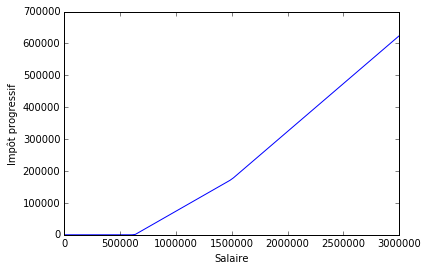

In [48]:
plt.plot(salaire, impot_progressif)
plt.xlabel(u'Salaire')
plt.ylabel(u'Impôt progressif')

In [49]:
from openfisca_core import rates

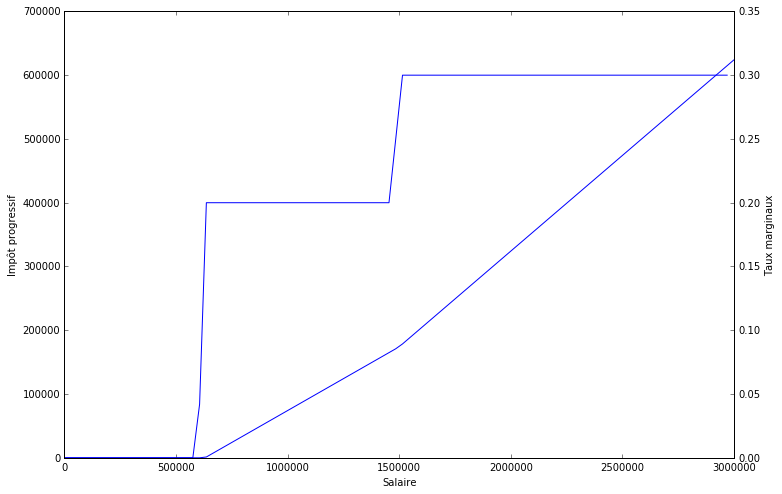

In [63]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(salaire, impot_progressif)
ax1.set_xlabel(u'Salaire')
ax1.set_ylabel(u'Impôt progressif')

ax2 = ax1.twinx()
ax2.set_ylabel(u'Taux marginaux')
ax2.plot(
    salaire[:-1],
    1 - rates.marginal_rate(target=impot_progressif, varying=salaire),
)